# FeatureEstimationDemo

### Read example BIDS data 

In this demo the basic offline workflow of py_neuromodulation will be demonstrated. For that, the example BIDS dataset in *pyneuromodulation/examples/data/* will be analyzed. 
The parametrization `nm_settings.json` is stored in the package directory *pyneuromodulation/nm_settings.json*, a `nm_channels.csv` is created given the *channel_type* information from the BIDS data. 

A projection will be defined based on the *pyneuromodulation/grid_cortex.tsv* and *pyneuromodulation/grid_subcortex.tsv* files. Band power features and sharpwave features will then be estimated and projected to the provided grid. 

First, necessary modules will be included and the BIDS_PATH and RUN_PATH, the path to the BIDS brainvision run file, will be defined given the example.

In [1]:
import py_neuromodulation as pn
from py_neuromodulation import nm_analysis, nm_normalization
import pandas as pd
import os
import numpy as np
import scipy
from matplotlib import pyplot as plt

PATH_BIDS = os.path.join(pn.__path__[0], "..", "examples", "data")
PATH_RUN = os.path.join(
    PATH_BIDS,
    "sub-testsub",
    "ses-EphysMedOff",
    "ieeg",
    "sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_ieeg.vhdr"
)
PATH_OUT = os.path.join(
    PATH_BIDS,
    'derivatives'
)

In [2]:
pn_stream = pn.nm_BidsStream.BidsStream(
    PATH_RUN=PATH_RUN,
    PATH_BIDS=PATH_BIDS,
    PATH_OUT=PATH_OUT
)

Extracting parameters from C:\Users\ICN_admin\Documents\py_neuromodulation\py_neuromodulation\..\examples\data\sub-testsub\ses-EphysMedOff\ieeg\sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Documents\py_neuromodulation\py_neuromodulation\..\examples\data\sub-testsub\ses-EphysMedOff\ieeg\sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_channels.tsv.
Reading in coordinate system frame MNI152NLin2009bAsym: None.
Reading electrode coords from C:\Users\ICN_admin\Documents\py_neuromodulation\py_neuromodulation\..\examples\data\sub-testsub\ses-EphysMedOff\ieeg\sub-testsub_ses-EphysMedOff_acq-StimOff_space-mni_electrodes.tsv.


C:\Users\ICN_admin\Documents\py_neuromodulation\py_neuromodulation\nm_IO.py:41: RuntimeWarning: Did not find any events.tsv associated with sub-testsub_ses-EphysMedOff_task-buttonpress_run-0.

The search_str was "C:\Users\ICN_admin\Documents\py_neuromodulation\py_neuromodulation\..\examples\data\sub-testsub\**\ieeg\sub-testsub_ses-EphysMedOff*events.tsv"
  raw_arr = mne_bids.read_raw_bids(bids_path)
C:\Users\ICN_admin\Documents\py_neuromodulation\py_neuromodulation\nm_IO.py:41: RuntimeWarning: iEEG Coordinate frame MNI152NLin2009bAsym is not a readable BIDS keyword by mne-bids yet. The allowed keywords are: ['ACPC', 'Pixels', 'Other']
  raw_arr = mne_bids.read_raw_bids(bids_path)
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\ICN_admin\Anaconda3\envs\pn_env\lib\logging\__init__.py", line 1079, in emit
    msg = self.format(record)
  File "C:\Users\ICN_admin\Anaconda3\envs\pn_env\lib\logging\__init__.py", line 923, in format
    return fmt.format(record)
  Fil

Next, the used settings will be read, and mne-bids will be used to read the example data.

Let's check the specified `nm_channels` dataframe: 

In [3]:
pn_stream.nm_channels

,name,rereference,used,target,type,status,new_name
0,ANALOG_R_ROTA_CH,None,0,0,misc,good,ANALOG_R_ROTA_CH
1,ECOG_L_1_SMC_AT,average,1,0,ecog,good,ECOG_L_1_SMC_AT-avgref
2,ECOG_L_2_SMC_AT,average,1,0,ecog,good,ECOG_L_2_SMC_AT-avgref
3,ECOG_L_3_SMC_AT,average,1,0,ecog,good,ECOG_L_3_SMC_AT-avgref
4,ECOG_L_4_SMC_AT,average,1,0,ecog,good,ECOG_L_4_SMC_AT-avgref
5,ECOG_L_5_SMC_AT,average,1,0,ecog,good,ECOG_L_5_SMC_AT-avgref
6,ECOG_L_6_SMC_AT,average,1,0,ecog,good,ECOG_L_6_SMC_AT-avgref
7,EEG_AO,None,0,0,misc,good,EEG_AO
8,LFP_L_1_STN_BS,LFP_L_567_STN_BS,1,0,seeg,good,LFP_L_1_STN_BS-LFP_L_567_STN_BS
9,LFP_L_234_STN_BS,LFP_L_1_STN_BS,1,0,seeg,good,LFP_L_234_STN_BS-LFP_L_1_STN_BS


The data contains depth LFP electrodes from the Subthalamic Nucleus (STN) and a ECoG strip electrode. Bipolar rereferencing was defined by default for the depth electrodes, and common average rereference for the ECoG electrodes. 
Importantly *ANALOG_ROT_R_1* is used as a target channel. After feature estimation, this channel will be normalized and added in a time aligned manner to the features output csv file. 

Next we will check the used settings:

In [4]:
pn_stream.settings

{'out_path': 'C:\\Users\\ICN_admin\\Documents\\py_neuromodulation\\examples\\rt_example',
 'sampling_rate_features': 10,
 'methods': {'raw_resampling': True,
  'raw_normalization': False,
  'feature_normalization': True,
  'kalman_filter': True,
  're_referencing': True,
  'notch_filter': True,
  'bandpass_filter': False,
  'stft': True,
  'fft': False,
  'raw_hjorth': True,
  'sharpwave_analysis': True,
  'return_raw': True,
  'project_cortex': True,
  'project_subcortex': True,
  'coherence': False},
 'raw_resampling_settings': {'resample_freq': 1000},
 'raw_normalization_settings': {'normalization_time': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'feature_normalization_settings': {'normalization_time': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'kalman_filter_settings': {'Tp': 0.1,
  'sigma_w': 0.7,
  'sigma_v': 1,
  'frequency_bands': ['theta',
   'alpha',
   'low beta',
   'high beta',
   'low gamma',
   'high gamma',
   'HFA']},
 'stft_settings': {'windowl

Many signal processing and feature estimation parameters are here defined. Most importantly the `setttings["methods"]` tells us which signal processing and features should be estimated: 

In [5]:
pn_stream.settings["methods"]

{'raw_resampling': True,
 'raw_normalization': False,
 'feature_normalization': True,
 'kalman_filter': True,
 're_referencing': True,
 'notch_filter': True,
 'bandpass_filter': False,
 'stft': True,
 'fft': False,
 'raw_hjorth': True,
 'sharpwave_analysis': True,
 'return_raw': True,
 'project_cortex': True,
 'project_subcortex': True,
 'coherence': False}

As defined, data will be **resampled**, **normalized** and **rereferenced** (as defined in the nm_channels) before feature estimation. Then, **bandpower features**, **sharpwave features** and **hjorth parameters** are calculated. Additionally, gamma band features will be Kalman filtered. Since *project_cortex* is set to true, projection to a grid is also enabled. 

### Grid projection

Next we will read the cortical grid, defined in *pyneuromodulation/grid_cortex.tsv*, and calculate the **projection matrix** from individual channels to the grid:

We can now inspect the individual coordinates, and the projected grid points. Therfore we read first a standard MNI hull, defined in the plot folder:

Since the grid is defined for the left hemisphere, we might switch the x coordinates for right electrodes. Then the ECoG channel coordinates and used grid points are visualized:  

In [6]:
pn_stream._set_run()

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)



In [7]:
feature_reader = nm_analysis.Feature_Reader(
        feature_dir=PATH_OUT,
        feature_file=PATH_RUN
    )

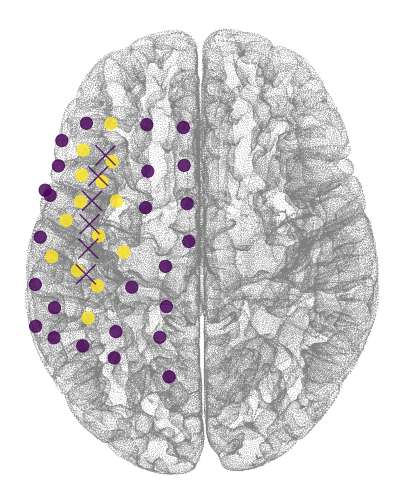

In [8]:
feature_reader.plot_cort_projection()

As visible, only grid points are active (channel data is projected unto them as shown in yellow) within the *max_dist* of every individual channel for the cortical and subcortical grid (as specified in the `nm_settings.json`). 

Next, the **rereference** and **resample** classes get instantiated, and an acquisition system is simulated by a **generator**:

### Feature Estimation 

Now the used **feature** and **run_analysis** classes are instantiated. Here FIR Filters and Kalman Filters are parametrized. During online feature estimation filters only have to be applied, instead of a repetitive calculatation, which saves computational time. 

Given the previously initialized generator, we can now receive a first data batch of 1 sec in shape (channels, samples): 

In [9]:
ieeg_batch = next(pn_stream.gen, None)

This allows us to estimate the previously assigned features:

In [10]:
ieeg_batch.shape

(15, 1375)

In [11]:
if ieeg_batch is not None:
    feature_series = pn_stream.run_analysis.process_data(
        ieeg_batch
    )

Last batch took: 0.08 seconds


In [12]:
feature_series

ECOG_L_1_SMC_AT-avgref_RawHjorth_Activity          0.0
ECOG_L_1_SMC_AT-avgref_RawHjorth_Mobility          0.0
ECOG_L_1_SMC_AT-avgref_RawHjorth_Complexity        0.0
ECOG_L_1_SMC_AT-avgref_raw                         0.0
ECOG_L_1_SMC_AT-avgref_Sharpwave_Max_prominence    0.0
                                                  ... 
gridsubcortex_866_stft_HFA                         0.0
gridsubcortex_878_stft_HFA                         0.0
gridsubcortex_879_stft_HFA                         0.0
gridsubcortex_891_stft_HFA                         0.0
gridsubcortex_1082_stft_HFA                        0.0
Length: 420, dtype: float64

As seen above already 1629 features are calculated based on this data batch. For every analyzed data batch, a subsequent row is appended to the run_analysis_.feature_arr. Let's show some features for a signle channel: 

In [12]:
pd.DataFrame(feature_series).T

,ECOG_L_1_SMC_AT-avgref_RawHjorth_Activity,ECOG_L_1_SMC_AT-avgref_RawHjorth_Mobility,ECOG_L_1_SMC_AT-avgref_RawHjorth_Complexity,ECOG_L_1_SMC_AT-avgref_raw,ECOG_L_1_SMC_AT-avgref_Sharpwave_Max_prominence,ECOG_L_1_SMC_AT-avgref_Sharpwave_Mean_interval,ECOG_L_1_SMC_AT-avgref_Sharpwave_Max_sharpness,ECOG_L_1_SMC_AT-avgref_stft_theta,ECOG_L_1_SMC_AT-avgref_stft_alpha,ECOG_L_1_SMC_AT-avgref_stft_low beta,...,gridsubcortex_866_stft_high gamma,gridsubcortex_878_stft_high gamma,gridsubcortex_879_stft_high gamma,gridsubcortex_891_stft_high gamma,gridsubcortex_1082_stft_high gamma,gridsubcortex_866_stft_HFA,gridsubcortex_878_stft_HFA,gridsubcortex_879_stft_HFA,gridsubcortex_891_stft_HFA,gridsubcortex_1082_stft_HFA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
ch = 'ECOG_AT_SM_L_1'
ch_cols = [
    f_
    for f_ in pd.DataFrame(feature_series).T.columns
    if ch in f_
]

### Sharpwave features
Now let's investigate sharpwave features. First, data for a specific channel is bandpass filtered in a predefined range (here 5 - 80 Hz).

In [16]:
normalize_samples = int(pn_stream.settings["raw_normalization_settings"]["normalization_time"] * pn_stream.fs)
raw_norm = nm_normalization.normalize_raw(
    ieeg_batch,
    None,
    normalize_samples,
    pn_stream.fs,
    method='mean',
    clip=False
)[0]

C:\Users\ICN_admin\Documents\py_neuromodulation\py_neuromodulation\nm_normalization.py:145: RuntimeWarning: invalid value encountered in true_divide
  current = (current - mean) / mean


Then troughs and peaks are identified, subsequently different features are estimated. 

In this example plot, the trough sharpness is visualized for the estimated data batch:

In [18]:
# data is being filtered in get_sharpwave_features
ch_idx = 10
data = raw_norm[ch_idx,:]
pn_stream.features.sw_features.initialize_sw_features() 

pn_stream.features.sw_features.filtered_data = np.convolve(
    data,
    pn_stream.features.sw_features.filter,
    mode='same'
)

pn_stream.features.sw_features.analyze_waveform()
trough_dist = pn_stream.features.sw_features.sw_settings["detect_troughs"]["distance_troughs"]
peak_dist = pn_stream.features.sw_features.sw_settings["detect_troughs"]["distance_peaks"]    

peaks = scipy.signal.find_peaks(
    pn_stream.features.sw_features.filtered_data,
    distance=peak_dist
)[0]
troughs = scipy.signal.find_peaks(
    -pn_stream.features.sw_features.filtered_data,
    distance=trough_dist
)[0]


<Figure size 2700x1050 with 0 Axes>

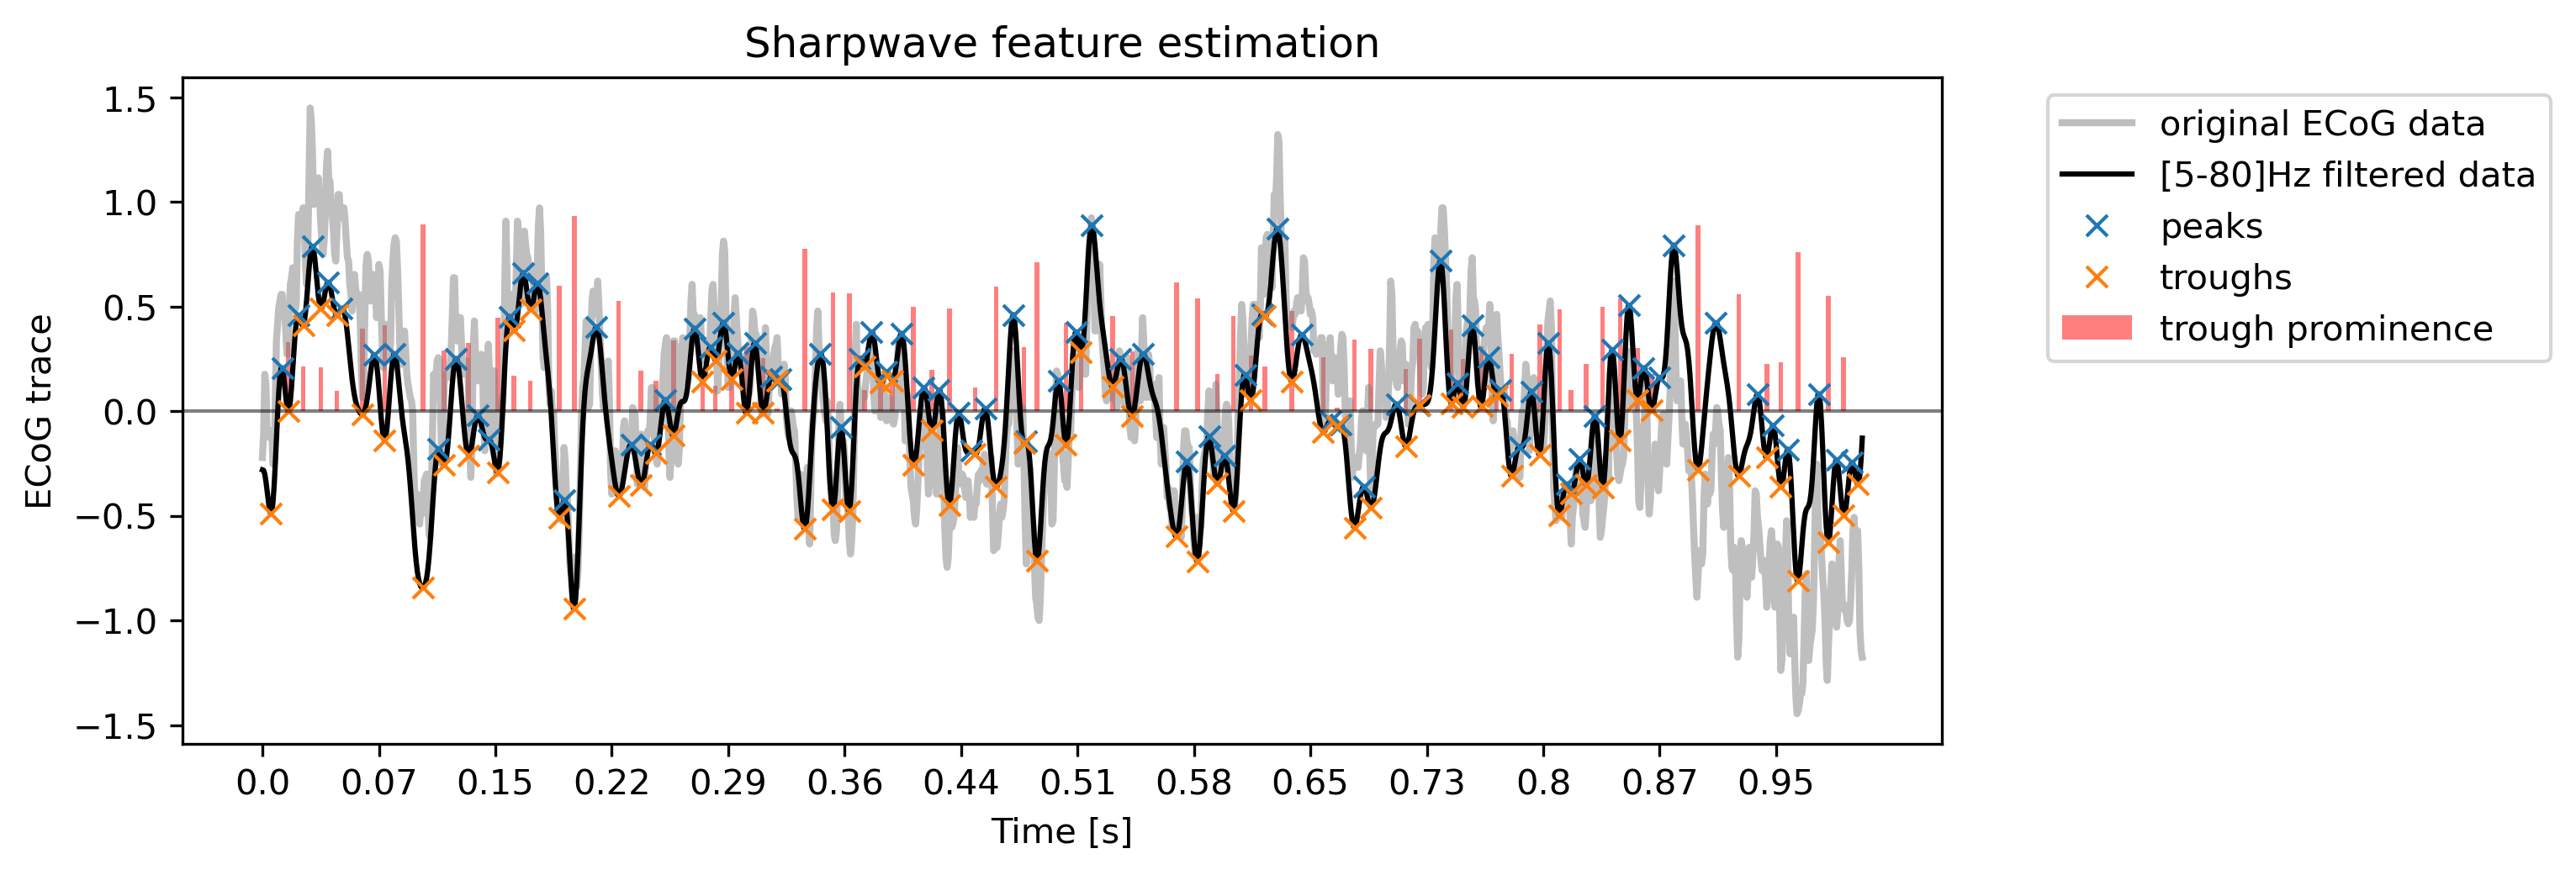

In [19]:
time_ = np.arange(0, data.shape[0], 1)/1375
plt.figure(figsize=(9,3.5), dpi=300)

plt.figure(figsize=(9,3.5), dpi=300)
plt.plot(data, color="gray", linewidth=2, alpha=0.5, label="original ECoG data")
plt.plot(pn_stream.features.sw_features.filtered_data, color="black", label="[5-80]Hz filtered data")
plt.plot(peaks, pn_stream.features.sw_features.filtered_data[peaks], "x", label="peaks")
plt.plot(troughs, pn_stream.features.sw_features.filtered_data[troughs], "x", label="troughs")
plt.bar(troughs[1:-1], pn_stream.features.sw_features.prominence, width=4, color="red",
       label="trough prominence", alpha=0.5)

plt.axhline(0, linewidth=1, color="black", alpha=0.5)
plt.xticks(np.arange(0, 1375, 100), np.round(np.arange(0, 1375, 100)/1375,2))
plt.xlabel("Time [s]")
plt.ylabel("ECoG trace")
plt.title("Sharpwave feature estimation")
plt.legend(bbox_to_anchor=(1.05, 1))

As seen above this sharpness characteristic is a useful feature for any decoding analysis, and might represent additional signal decoding characteristics. Since in one data batch a different number of peaks and troughs can be detected, the returning feature_arr included features of certain predefined operations on these sharpwave characteristics within this batch. Those are defined in the "estimator" key:

In [20]:
pn_stream.settings["sharpwave_analysis_settings"]

{'sharpwave_features': {'peak_left': False,
  'peak_right': False,
  'trough': False,
  'width': False,
  'prominence': True,
  'interval': True,
  'decay_time': False,
  'rise_time': False,
  'sharpness': True,
  'rise_steepness': False,
  'decay_steepness': False,
  'slope_ratio': False},
 'filter_low_cutoff': 5,
 'filter_high_cutoff': 80,
 'detect_troughs': {'estimate': True,
  'distance_troughs': 10,
  'distance_peaks': 5},
 'detect_peaks': {'estimate': True,
  'distance_troughs': 5,
  'distance_peaks': 10},
 'estimator': {'mean': ['interval'],
  'median': None,
  'max': ['prominence', 'sharpness'],
  'min': None,
  'var': None},
 'apply_estimator_between_peaks_and_troughs': True}

E.g. in this example the median, max, min and variance of all sharpness features would be returned. 